In [1]:
import logging

import numpy as np
import pairinteraction.backend.double as pi
from pairinteraction.units import ureg

logging.basicConfig(level=logging.INFO, format="%(levelname)s - %(message)s")

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

pi.initialize_global_database(download_missing=True, allow_overwrite=True)

[2024-12-16 19:06:00.828 1970901] [info] [Database.cpp:201] Accessing database repository path: /repos/pairinteraction/database-sqdt/releases/latest
[2024-12-16 19:06:01.002 1970901] [info] [Database.cpp:236] Using cached overview of available tables.
[2024-12-16 19:06:01.003 1970901] [info] [Database.cpp:201] Accessing database repository path: /repos/pairinteraction/database-mqdt/releases/latest
[2024-12-16 19:06:01.005 1970901] [info] [Database.cpp:236] Using cached overview of available tables.
[2024-12-16 19:06:01.287 1970901] [info] [Database.cpp:292] Availability of database tables for species and Wigner 3j symbols:
[2024-12-16 19:06:01.287 1970901] [info] [Database.cpp:294] * Sr88_mqdt (locally available: false, up to date: false, fully downloaded: false)
[2024-12-16 19:06:01.287 1970901] [info] [Database.cpp:294] * Yb171_mqdt (locally available: true, up to date: true, fully downloaded: false)
[2024-12-16 19:06:01.287 1970901] [info] [Database.cpp:294] * Sr88_triplet (locally 

In [2]:
import logging
import time
from functools import wraps


def log_execution_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        logger.info(f"Function '{func.__name__}' executed in {execution_time:.4f} seconds")
        return result

    return wrapper

In [3]:
@log_execution_time
def find_potential_foerster(ket1: pi.KetAtom, ket2: pi.KetAtom, settings: dict) -> dict:
    delta_n = settings.get("delta_n", 6)
    delta_l = settings.get("delta_l", 5)
    delta_m = settings.get("delta_m", 5)
    additional_kets = settings.get("additional_kets", [])

    kets = [ket1, ket2]
    logger.debug("Kets of interest: %s", [ket.label for ket in kets])
    bases = [
        pi.BasisAtom(
            species=ket.species,
            n=(ket.n - delta_n, ket.n + delta_n),
            l=(ket.l - delta_l, ket.l + delta_l),
            m=(ket.m - delta_m, ket.m + delta_m),
            additional_kets=additional_kets,
        )
        for ket in kets
    ]
    logger.debug(
        "Number of states in the single atom bases: %s",
        [basis.number_of_states for basis in bases],
    )

    systems = [pi.SystemAtom(basis=basis) for basis in bases]
    e_field = settings.get("e_field", None)
    e_field_unit = settings.get("e_field_unit", "V/cm")
    b_field = settings.get("b_field", None)
    b_field_unit = settings.get("b_field_unit", "gauss")
    for system in systems:
        system.enable_diamagnetism(False)
        if e_field:
            system.set_electric_field(e_field, e_field_unit)
        if b_field:
            system.set_magnetic_field(b_field, b_field_unit)
    if not all(system.is_diagonal for system in systems):
        pi.diagonalize(systems, diagonalizer="Eigen", sort_by_energy=False)

    pair_energy = sum(
        pi.calculate_energy(ket, system, unit="GHz") for ket, system in zip(kets, systems)
    ) * ureg.Quantity(1, "GHz")
    logger.debug("Pair energy with fields: %s GHz", pair_energy.magnitude)
    logger.debug("Pair energy from kets: %s GHz", sum(ket.get_energy("GHz") for ket in kets))

    delta_pair_energy = settings.get("delta_pair_energy", 5) * ureg.Quantity(
        1, settings.get("delta_pair_energy_unit", "GHz")
    )
    basis_combined = pi.BasisCombined(
        systems,
        energy=(pair_energy - delta_pair_energy, pair_energy + delta_pair_energy),
    )
    system_combined = pi.SystemCombined(basis_combined)
    logger.debug("Number of states in the combined basis: %s", basis_combined.number_of_states)

    energy_gap = pair_energy - system_combined.get_eigenvalues("GHz") * ureg.Quantity(1, "GHz")
    overlaps = system_combined.basis.get_overlaps_with_product_state(ket1, ket2)
    ket_idx = np.argmax(overlaps)
    if overlaps[ket_idx] < 0.5:
        raise ValueError("The pair state of interest cannot be identified uniquely.")

    logger.debug(
        "pair energy: %s GHz, min energy gap: %s GHz, max energy gap: %s GHz",
        pair_energy,
        min(abs(energy_gap)),
        max(abs(energy_gap)),
    )

    distance = settings.get("distance", 100)
    distance_unit = settings.get("distance_unit", "micrometer")
    distance = ureg.Quantity(distance, distance_unit).to("micrometer").magnitude
    theta = settings.get("theta", 0)
    vector = np.array([np.sin(theta), 0, np.cos(theta)])
    system_combined.set_distance_vector(distance * vector, "micrometer")
    order = settings.get("order", 3)
    system_combined.set_order(order)

    build_combined_hamiltonian(system_combined)
    H = system_combined.get_hamiltonian("GHz")
    H_corresponding_row = H.getrow(ket_idx).toarray()[0] * distance**3 * ureg.Quantity(1, "GHz * micrometer^3")

    inds = np.arange(len(H_corresponding_row))
    inds = inds[inds != ket_idx]
    inds = inds[np.abs(H_corresponding_row[inds]) > 0]

    threshold_energy = settings.get("threshold_energy", 0.05) * ureg.Unit("GHz")
    if np.any(np.abs(energy_gap[inds]) < threshold_energy):
        logger.warning(f"involved kets: {np.array(basis_combined.kets)[inds]}")
        logger.warning(f"{energy_gap[inds]=}")
        logger.warning(f"{H_corresponding_row[inds]=}")
        raise ValueError(
            "Some states that are coupled to the state of interest are energetically too close, "
            "consider calculating the effective Hamiltonian."
        )

    C6 = np.dot(H_corresponding_row[inds] ** 2, 1 / energy_gap[inds])  # unit: GHz * mum^6

    threshold_C3 = settings.get("threshold_C3", 1e-1) * ureg.Unit(
        settings.get("threshold_C3_unit", "GHz * micrometer^3")
    )
    inds = inds[np.abs(H_corresponding_row[inds]) > threshold_C3]
    inds = inds[np.argsort(np.abs(H_corresponding_row[inds]))[::-1]]

    np.set_printoptions(threshold=10)
    kets = np.array(basis_combined.kets)[inds]
    energy_gap = energy_gap[inds]
    C3_coefficients = H_corresponding_row[inds]
    logger.info(f"{kets=}")
    logger.info(f"{energy_gap=}")
    logger.info(f"{C3_coefficients=}")
    logger.info(f"{C6=}")

    data = {
        "basis_combined": basis_combined,
        "ket_combined_of_interest": basis_combined.kets[ket_idx],
        "kets": kets,
        "energy_gap": energy_gap,
        "C3_coefficients": C3_coefficients,
        "C6": C6,
        "inds": inds,
    }
    return data


@log_execution_time
def build_combined_hamiltonian(system_combined: pi.SystemCombined) -> None:
    # TODO: this is rather slow, optimize this at some point to only calculate the necessary rows of the Hamiltonian
    system_combined.get_hamiltonian()

In [4]:
import matplotlib.pyplot as plt


def plot_potential_foerster(data: dict, show_plot: bool = False):
    kets: list[pi.KetAtom] = data["kets"]
    energy_gap = data["energy_gap"]
    C3_coefficients = data["C3_coefficients"]
    C6 = data["C6"]

    energies = np.abs(energy_gap)
    C3 = np.abs(C3_coefficients)
    labels = np.array([ket.label for ket in kets])

    # sort by energy
    inds = np.argsort(np.abs(energy_gap))
    energies = energies[inds]
    C3 = C3[inds]
    labels = labels[inds]

    fig, ax = plt.subplots()

    x = np.arange(len(energies))
    colors = C3.to("GHz um^3").magnitude
    sizes = 1 + (colors / np.max(colors)) * 200
    scatter = ax.scatter(
        x,
        energies.to("GHz").magnitude,
        s=sizes,
        c=colors,
        cmap="viridis_r",  # "afmhot_r",
        vmin=0,
    )
    plt.colorbar(scatter, label=r"C3 Value [GHz $\mu m^3$]")

    ax.set_xticks(x, labels, rotation=45, ha="right")
    ax.set_xlabel(None)
    ax.set_ylabel("Energy Gap [GHz]")
    ax.set_title(data["ket_combined_of_interest"].label + rf" - C6: {C6.to('GHz um^6').magnitude:.2f} GHz $\mu m^6$")
    fig.tight_layout()
    plt.show()

In [5]:
ket1 = pi.KetAtom("Rb", n=80, l=0, j=0.5, m=0.5)
ket2 = pi.KetAtom("Rb", n=81, l=0, j=0.5, m=0.5)
settings = {
    "b_field": [0, 0, 60.7],
    "delta_pair_energy": 2,
}

data = find_potential_foerster(ket1, ket2, settings)

DEBUG - Kets of interest: ['Rb:80,S_1/2,1/2', 'Rb:81,S_1/2,1/2']
DEBUG - Number of states in the single atom bases: [923, 923]
DEBUG - Pair energy with fields: -1099.15234945484 GHz
DEBUG - Pair energy from kets: -1099.322460908632 GHz
DEBUG - Number of states in the combined basis: 12805
DEBUG - pair energy: -1099.15234945484 gigahertz GHz, min energy gap: 0.0 gigahertz GHz, max energy gap: 1.999808812542824 gigahertz GHz


[2024-12-16 19:06:01.704 1970901] [warning] [Database.cpp:786] No state found with the requested minimum quantum number l. Requested: -5, found: 0.
[2024-12-16 19:06:01.760 1970901] [warning] [Database.cpp:786] No state found with the requested minimum quantum number l. Requested: -5, found: 0.


INFO - Function 'build_combined_hamiltonian' executed in 0.3025 seconds
INFO - kets=array([Rb:80,P_3/2,1/2; Rb:80,P_3/2,1/2, Rb:79,P_3/2,1/2; Rb:81,P_3/2,1/2,
       Rb:80,P_1/2,1/2; Rb:80,P_3/2,1/2, ...,
       Rb:81,P_1/2,1/2; Rb:79,P_3/2,1/2,
       Rb:81,P_3/2,3/2; Rb:79,P_1/2,-1/2,
       Rb:81,P_1/2,-1/2; Rb:79,P_3/2,3/2], dtype=object)
INFO - energy_gap=<Quantity([0.20320338 0.75454051 0.43381149 ... 0.97850689 0.94500531 0.93120803], 'gigahertz')>
INFO - C3_coefficients=<Quantity([ 23.34621358  23.34087203 -11.14226394 ...  -0.1736498   -0.16721502
  -0.15051582], 'gigahertz * micrometer ** 3')>
INFO - C6=<Quantity(6297.90063, 'gigahertz * micrometer ** 6')>
INFO - Function 'find_potential_foerster' executed in 0.6423 seconds


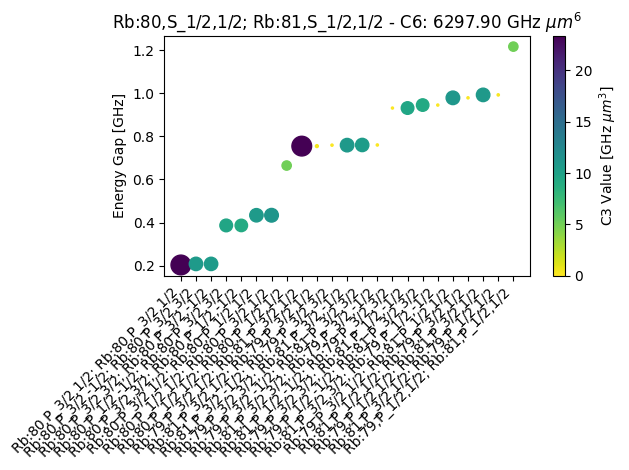

In [6]:
plot_potential_foerster(data)